# Merging/Cleaning Worker Exploitation Data (California Only)

The main steps in this notebook are as follows, with annotations and elaborations for each provided.


PART 1: DOL Wage and Hour Compliance Data  
- Limit to California only for now  
- Create violation type reference to violation group  
- Create a  *non violator* flag for investigations that failed to uncover violations  
- Extract 3 digit NAICS  

Part 2: Census Bureau Statistics of US Businesses (SUSB) Survey Data 

- Get Census SUSB workforce employment statistics at the MSA level, by 3 digit NAICS  
- Get zip codes by MSA  
- Merge zip codes into the MSA dataset  

Part 3: Combine Part 1 and Part 2  
- Merge the two by zip code and 3 digit NAICS  
- Aggregate numbers to the MSA level  

We now have violation dataset with SUSB employment numbers at MSA level.  

In [126]:
import csv
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import requests
import json
import seaborn as sbrn
import urllib2
import re
import pickle
from sklearn.cluster import k_means
import scipy.spatial as sp
import whd_utilities as whduts #my own python script for accompanying utility functions

%matplotlib inline


# Part 1: D.O.L. Wage and Hour Compliance Data  

The dataset [here](http://ogesdw.dol.gov/views/data_summary.php) contains all concluded investigations since 2007. Each record is a concluded investigation for a particular company with attributes including, but not limited to:  
* 6 digit NAICS industry code  
* "Findings" start and end dates: Note it is made clear that these are not the same as the case open and closed dates (which are not available). In essence, any record could span violations of various types and amounts over a 25-30 year period. Findings start date go as far back as 1985, and are as recent as 2015, with some seemingly erroneous data points such as 2024.  
* Around 31 different government act violations. For **example**, the *[MSPA](https://www.dol.gov/whd/mspa/) - Migrant and Seasonal Agricultural Worker Protection Act* aims to protect "...migrant and seasonal agricultural workers by establishing employment standards related to wages, housing, transportation, disclosures and recordkeeping."  
    * We see that any MSPA related violations that the company might have committed are logged under the *mspa_violtn_cnt* column  
    * Backwages owed to employees as a result of such violations are in the *mspa_bw_atp_amt* column  
    * Number of employees affected by these specific violations are in the *mspa_ee_atp_cnt* column  
    * Other penalties assessed by the D.O.L. W.H.D. specific to violations of this act are in *mspa_cmp_assd_amt*  
    
A data dictionary for the column names is available at the [DOL Enforcement site](http://ogesdw.dol.gov/views/data_summary.php) ('whd_data_dictionary.csv')

In [1]:
# enable this cell if dataset not downloaded to local, else read from local
# Uncompress the remote ZIP archive, and read the csv contained within. 

#import zipfile
#import requests
#import StringIO

# whd_url = 'http://prd-enforce-xfr-02.dol.gov/data_catalog/WHD/whd_whisard_20160611.csv.zip'
# r = requests.get(whd_url)
# z = zipfile.ZipFile(StringIO.StringIO(r.content))
# whd = pd.read_csv(z.open('whd_whisard.csv'), low_memory=False)

In [5]:
# read from local
whd_whisard = pd.read_csv('/Users/ash/Downloads/wage theft datasets/whd_whisard.csv', low_memory=False)


**To keep things relatively simple for now, we'll refrain from performing a nationwide analysis and look at California specific data.** 

In [8]:
whd_whisard_ca = whd_whisard[whd_whisard['st_cd']=='CA']


In [22]:
#sample output
pd.set_option('max_columns',110)
whd_whisard_ca.sample(3)

,case_id,trade_nm,legal_name,street_addr_1_txt,cty_nm,st_cd,zip_cd,naic_cd,naics_code_description,case_violtn_cnt,cmp_assd_cnt,ee_violtd_cnt,bw_atp_amt,ee_atp_cnt,findings_start_date,findings_end_date,flsa_violtn_cnt,flsa_repeat_violator,flsa_bw_atp_amt,flsa_ee_atp_cnt,flsa_mw_bw_atp_amt,flsa_ot_bw_atp_amt,flsa_15a3_bw_atp_amt,flsa_cmp_assd_amt,sca_violtn_cnt,sca_bw_atp_amt,sca_ee_atp_cnt,mspa_violtn_cnt,mspa_bw_atp_amt,mspa_ee_atp_cnt,mspa_cmp_assd_amt,h1b_violtn_cnt,h1b_bw_atp_amt,h1b_ee_atp_cnt,h1b_cmp_assd_amt,fmla_violtn_cnt,fmla_bw_atp_amt,fmla_ee_atp_cnt,fmla_cmp_assd_amt,flsa_cl_violtn_cnt,flsa_cl_minor_cnt,flsa_cl_cmp_assd_amt,dbra_cl_violtn_cnt,dbra_bw_atp_amt,dbra_ee_atp_cnt,h2a_violtn_cnt,h2a_bw_atp_amt,h2a_ee_atp_cnt,h2a_cmp_assd_amt,flsa_smw14_violtn_cnt,flsa_smw14_bw_amt,flsa_smw14_ee_atp_cnt,cwhssa_violtn_cnt,cwhssa_bw_amt,cwhssa_ee_cnt,...,osha_bw_atp_amt,osha_ee_atp_cnt,osha_cmp_assd_amt,eppa_violtn_cnt,eppa_bw_atp_amt,eppa_ee_cnt,eppa_cmp_assd_amt,h1a_violtn_cnt,h1a_bw_atp_amt,h1a_ee_atp_cnt,h1a_cmp_assd_amt,crew_violtn_cnt,crew_bw_atp_amt,crew_ee_atp_cnt,crew_cmp_assd_amt,ccpa_violtn_cnt,ccpa_bw_atp_amt,ccpa_ee_atp_cnt,flsa_smwpw_violtn_cnt,flsa_smwpw_bw_atp_amt,flsa_smwpw_ee_atp_cnt,flsa_hmwkr_violtn_cnt,flsa_hmwkr_bw_atp_amt,flsa_hmwkr_ee_atp_cnt,flsa_hmwkr_cmp_assd_amt,ca_violtn_cnt,ca_bw_atp_amt,ca_ee_atp_cnt,pca_violtn_cnt,pca_bw_atp_amt,pca_ee_atp_cnt,flsa_smwap_violtn_cnt,flsa_smwap_bw_atp_amt,flsa_smwap_ee_atp_cnt,flsa_smwft_violtn_cnt,flsa_smwft_bw_atp_amt,flsa_smwft_ee_atp_cnt,flsa_smwl_violtn_cnt,flsa_smwl_bw_atp_amt,flsa_smwl_ee_atp_cnt,flsa_smwmg_violtn_cnt,flsa_smwmg_bw_atp_amt,flsa_smwmg_ee_atp_cnt,flsa_smwsl_violtn_cnt,flsa_smwsl_bw_atp_amt,flsa_smwsl_ee_atp_cnt,eev_violtn_cnt,h2b_violtn_cnt,h2b_bw_atp_amt,h2b_ee_atp_cnt,sraw_violtn_cnt,sraw_bw_atp_amt,sraw_ee_atp_cnt,ld_dt,findings_span
59151,1753254,Punzalan Homes,"Punzalan Homes, Inc",13314 Ashworth St.,Cerritos,CA,90703.0,6239,Other Residential Care Facilities,3,0.0,1,20.00,1,2013-02-18,2015-02-17,3,NaN,20.00,1,0.00,20.00,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,2016-02-19 01:00:04.033708,729 days
180481,1383990,Big Ben's Meat Market Corporation dba,Big Ben's Meat Market,108 E. 8th Street,National City,CA,91950.0,445110,Supermarkets and Other Grocery (except Conveni...,0,0.0,0,0.00,0,2002-11-15,2004-11-15,0,NaN,0.00,0,0.00,0.00,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,2015-02-20 01:00:06.112241,731 days
140829,1651168,"Enough Apparel, Inc.","Enough Apparel, Inc.",2448 E. 8th Street,Los Angeles,CA,90021.0,31523,Women's and Girls' Cut and Sew Apparel Manufac...,106,0.0,57,26474.02,0,2011-07-15,2012-05-15,106,NaN,26474.02,0,9744.58,16729.44,0.0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0.0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0,0.0,0,2015-02-20 01:00:06.112241,305 days


---

## Investigations Reveal Violations Over Time  

The [data dictionary](http://ogesdw.dol.gov/views/data_summary.php) tells us that the *findings_start_date* and *findings_end_date* indicate the span of time over which the violations for the investigated case might have occurred. In this case the span is anywhere from 1985 to 2015! This creates a major headache when we (later) try to hunt for industry group specific survey data such as size of the workforce of an industry group. This is because such survey data - typically scattered at the Census Bureau or the Bureau of Labor Statistics - are available on an annual or quarterly basis. A substantial data acquisition and aggregating exercise will have to be performed in order to get the relevant industry numbers by specific year. The next step will probably involve adopting an *imperfect* method of averaging out such survey numbers for the span of the violations for ech investigation. This is imperfect because there may be variations in industry workforce over such a span, that any averaging strategy will be compromising.  

Nevertheless, for now, we'll simply extract the span over which these violations occurred for each investigation and figure out a strategy to deal with this as we define our problem space.  

In [19]:
whd_whisard_ca['findings_span'] = pd.to_datetime(whd_whisard_ca.findings_end_date, errors='coerce') - pd.to_datetime(whd_whisard_ca.findings_start_date, errors='coerce')

/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


---  

## Grouping Violations  

There are too many individual violation types (31 total, along with employees affected, backwages owed, and # of violations, for each), enough to make feature engineering and any imputing strategies a very tedious affair. For a first pass, we'll focus on the total overall violations, Minimum Wage, Below Minimum Wage, and Child Labor related violations. Every other kind will be grouped into an "Other" bucket. 

To summarise the proceeding steps, we create groups of major violation types that:  
* The DOL W.H.D. deems as _interesting_ a.k.a _severe_ violations  
* That likely affect "at-risk" populations (justifying the WHD's interest in uncovering these)  

These groups include three pieces of information including:  
* the number of violation cases uncovered *per* investigation (per *case id*)  
* the backwages owed as a result of these violations  
* the number of employees affected by these violations  

And, the groups that all the violations are going to be rolled up into, are:  
* Minimum Wage Violations
* Below Minimum Wage Violations  
* Child Labor Violations  
* All Other Violations  
* Totals 


*Note: A data dictionary for the column names is available at the [DOL Enforcement site](http://ogesdw.dol.gov/views/data_summary.php) ('whd_data_dictionary.csv')*   

---


We'll store the mapping from specific violations into their general groupings in a hash map.

In [25]:
# columns that don't get grouped
constant_cols = ['trade_nm','cty_nm','zip_cd','st_cd','naic_cd','naics_code_description', 'findings_span',
           'case_violtn_cnt','cmp_assd_cnt','ee_violtd_cnt','ee_atp_cnt']

#Note: I'm screwing up the Python variable naming convention on purpose, just this one time :)
#dictionary mapping: columns we want to group as values, the larger group as keys
ref_map = {'MinWage_Cases':['flsa_violtn_cnt'],
           'MinWage_ATPAmt':['flsa_bw_atp_amt','flsa_mw_bw_atp_amt'],
           'MinWage_EmpAff':['flsa_ee_atp_cnt'],
           'ChildLabor_Cases':['flsa_cl_violtn_cnt'],
           'ChildLabor_ATPAmt':['flsa_cl_cmp_assd_amt'],
           'ChildLabor_EmpAff':['flsa_cl_minor_cnt'],
           'BelowMinWage_Cases':['flsa_smw14_violtn_cnt','flsa_smwpw_violtn_cnt','flsa_smwap_violtn_cnt',
               'flsa_smwft_violtn_cnt', 'flsa_smwl_violtn_cnt','flsa_smwmg_violtn_cnt','flsa_smwsl_violtn_cnt'],
           'BelowMinWage_ATPAmt':['flsa_smw14_bw_amt','flsa_smwpw_bw_atp_amt','flsa_smwap_bw_atp_amt',
               'flsa_smwft_bw_atp_amt', 'flsa_smwl_bw_atp_amt','flsa_smwmg_bw_atp_amt','flsa_smwsl_bw_atp_amt'],
           'BelowMinWage_EmpAff':['flsa_smw14_ee_atp_cnt','flsa_smwpw_ee_atp_cnt','flsa_smwap_ee_atp_cnt',
               'flsa_smwft_ee_atp_cnt', 'flsa_smwl_ee_atp_cnt','flsa_smwmg_ee_atp_cnt','flsa_smwsl_ee_atp_cnt']}

I created a convenient module specific for this exercise (*whd_utilities*) that contains some useful functions. *WHD_pack_violtn_grps* below takes in the target data frame, the not-to-be-grouped columns, and the grouping hash map above, and rolls up the individual violation types into their larger group. 

In [27]:
#call my function that sums up the individual columns into their groups (dictionary keys are the groups)
whd_grps = whduts.WHD_pack_violtn_grps(whd_whisard_ca, constant_cols, ref_map)

Almost there! Before we group all "Other" violations into one bucket, we need a total backwages owed column (this is missing from the original dataset with the total employees affected, violations, etc.). Then we can calculate the "Other" violation totals by subtracting from the overall total columns.

In [28]:
dat['All_ATPAmt']=np.sum(whd_whisard[whd_whisard_ca.columns[whd_whisard_ca.columns.str.endswith('_atp_amt')]], axis=1)

/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
# Sum up all violations specific to all other violation types not considered above

dat['Other_Cases']=abs(dat['case_violtn_cnt']-np.sum(dat[['MinWage_Cases','ChildLabor_Cases','BMW_Cases']], axis=1))
dat['Other_ATPAmt']=abs(dat['All_ATPAmt']-np.sum(dat[['MinWage_ATPAmt','ChildLabor_ATPAmt','BMW_ATPAmt']], axis=1))
dat['Other_EmpAff']=abs(dat['ee_violtd_cnt']-np.sum(dat[['MinWage_EmpAff','ChildLabor_EmpAff','BMW_EmpAff']], axis=1))

/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

And here's an example of how our dataframe with grouped violations looks:  

In [31]:
dat.sample(3)

,trade_nm,cty_nm,zip_cd,st_cd,naic_cd,naics_code_description,case_violtn_cnt,cmp_assd_cnt,ee_violtd_cnt,ee_atp_cnt,MinWage_Cases,MinWage_ATPAmt,MinWage_EmpAff,ChildLabor_Cases,ChildLabor_ATPAmt,ChildLabor_EmpAff,BMW_Cases,BMW_ATPAmt,BMW_EmpAff,All_AtpAmt,Other_Cases,Other_ATPAmt,Other_EmpAff,All_ATPAmt
29215,South Seas Foods,Oxnard,93033.0,CA,311942,Spice and Extract Manufacturing,0,0.0,0,0,0,0.00,0,0,0.0,0,0,0.0,0,0.00,0,0.00,0,0.00
17292,"MLU Services, Inc",Twin Peaks,92391.0,CA,11311,Timber Tract Operations,117,0.0,87,87,87,93959.06,87,0,0.0,0,0,0.0,0,281877.18,30,187918.12,0,281877.18
98527,J.A. Farm Labor Inc.,Orosi,93647.0,CA,115115,Farm Labor Contractors and Crew Leaders,17,1875.0,7,7,1,0.00,0,0,0.0,0,0,0.0,0,696.00,16,696.00,7,696.00


Nice, we've managed to go from 109 features to 24. Granted, we're operating at a grouped violations level.

In [44]:
dat.shape

(19850, 24)

--- 

## All Zero Rows: Missing Values?  

On personal correspondence with the local DOL WHD, I learned that rows that have all zero entries across all violations are actually investigations conducted by WHD that *did not* turn up anything, or the evidence was insufficient to warrant classifying the incident as a violation. I'm glad I ran it by the DOL because I spent a considerable amount of time figuring out an elaborate *impute* strategy for what I thought were missing values. Goes to show the value of domain knowledge and subject matter expertise!  

### Flagging Non-Violators  

These 'missing' entries consist of almost 30% of the dataset and could serve as an important marker of predictors that help distinguish severe violators versus those that turn up duds. Therefore, for our purposes, let's *assume* for now that records with zeros across all violations are exemplars of non-violators, or at least investigations conducted by the WHD that have little payoff. We'll create a new feature *is_violator* where 1 indicates there is at least 1 violation type recorded.

In [45]:
#check the sum of all violation groups, employees affected, penalties owed. All '0's are non-violations.
#using the powerful and convenient numpy function where()
dat['is_violator'] = np.where(np.sum(dat.iloc[:,6:], axis=1) == 0, 0, 1)

/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Once again, because this could turn out to be important, investigations that didn't turn up any violations either because of insufficient evidence or for something else, are going to be assumed to be something like *low payoff* investigations. Perhaps there are some characteristics to these industries that either require substantial investigative effort or the nature of infractions simply don't warrant an investigation. **This sort of information might be very useful for DOL WHD resource management**.  

We see that close to 30% of California investigations conducted since 2007 have turned up non-violations.

(0, 1)

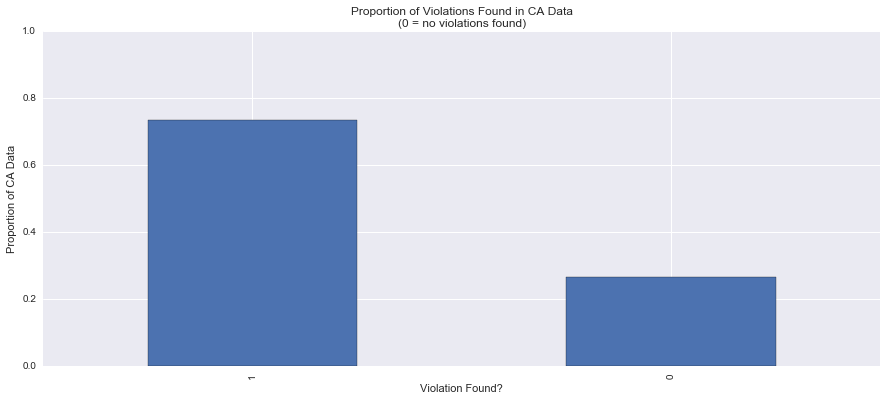

In [68]:
dat.is_violator.value_counts(normalize=True).plot(kind='bar', 
                                                  figsize=(15,6),
                                                 title='Proportion of Violations Found in CA Data\n(0 = no violations found)')
plt.xlabel('Violation Found?')
plt.ylabel('Proportion of CA Data')
plt.ylim(0,1)

--- 
## Breaking Out NAICS Code (Industry Group Hierarchy)

Now, the next step - and this'll become clear a little farther down - is to break out the 6 digit **NAICS** industry grouping assigned to each investigation into its 4, and maybe 3 digit hierarchies (first x digits). The main reason for this is because the survey data that we're later going to merge in is mostly *consistent* at the 3 digit NAICS level. A higher number of digits indicates a more evolving, granular hierarchy of industry types and these vary widely over the survey years. It becomes next to impossible to merge survey data by NAICS codes at the 5 or 6 digit levels because of non matching (mostly newer or modified codes) evolved over the years.  

For example:  
** NAICS hierarchy example goes here **

In [63]:
#this is easy, thanks to pandas' immensely handy string manipulation functions, and some basic regex
dat['NAICS4']=dat['naic_cd'].str.extract('(\d\d\d\d)', expand=False)
dat['NAICS3']=dat['naic_cd'].str.extract('(\d\d\d)', expand=False)
dat['NAICS2']=dat['naic_cd'].str.extract('(\d\d)', expand=False)


/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [64]:
dat.sample(3)

,trade_nm,cty_nm,zip_cd,st_cd,naic_cd,naics_code_description,case_violtn_cnt,cmp_assd_cnt,ee_violtd_cnt,ee_atp_cnt,MinWage_Cases,MinWage_ATPAmt,MinWage_EmpAff,ChildLabor_Cases,ChildLabor_ATPAmt,ChildLabor_EmpAff,BMW_Cases,BMW_ATPAmt,BMW_EmpAff,All_AtpAmt,Other_Cases,Other_ATPAmt,Other_EmpAff,All_ATPAmt,is_violator,NAICS4,NAICS3,NAICS2
180394,NorCal Presort,Redding,96001.0,CA,561499,All Other Business Support Services,1,1320.0,1,0,0,0.00,0,1,1320.0,1,0,0.0,0,0.00,0,1320.00,0,0.00,1,5614,561,56
200592,LA County Dept of Health Services-King Drew,Los Angeles,90059.0,CA,09660,Local Hospitals,0,0.0,1,0,0,0.00,0,0,0.0,0,0,0.0,0,0.00,0,0.00,1,0.00,1,0966,096,09
95788,All Century Insurance (Los Angeles),Los Angeles,90038.0,CA,524210,Insurance Agencies and Brokerages,8,0.0,7,7,8,18775.01,7,0,0.0,0,0,0.0,0,56325.03,0,37550.02,0,56325.03,1,5242,524,52


Our main DOL WHD features are ready for now. Let's save this dataset first.

In [65]:
dat.to_csv('./../data/california_violtns.csv')


---     

# PART 2: Merging Industry Group Data by Metropolitan Statistical Area (MSA)  

In order to begin to make any sense of the violations uncovered in our CA dataset, we'd like to get an idea of how these numbers compare to the industry group as a whole. This sort of data is scattered (and I do mean scattered) around various government data portals, the main ones being at the *Census Bureau* and the *Bureau of Labor Statistics*. Furthermore, I've decided to sidestep the problem of the span of violations over time for now in order to keep the data acquisition from getting out of control. For now, let's work with some industry specific numbers at the 3 digit NAICS level by Metropolitan Statistical Area (MSA) codes, as late as 2014. This dataset is available from the *Statistics of US Businesses* survey program over at the Census Bureau. 

The next few steps will prepare this dataset to be merged into the CA dataset we've created...

In [76]:
#remote
#msa_stats = pd.read_csv('http://www2.census.gov/econ/susb/data/2013/msa_3digitnaics_2013.txt')

#local
msa_stats = pd.read_csv('./../data/MSA_stats_2014.csv')

In [77]:
msa_stats.sample(3)

,Unnamed: 0,MSA,NAICS,ENTRSIZE,FIRM,ESTB,EMPL_N,EMPLFL_R,EMPLFL_N,PAYR_N,PAYRFL_N,MSADSCR,NAICSDSCR,entrsizedscr,NAICS3,NAICS3Desc
489377,489377,42740,713,5,8,8,0,B,S,251,H,"Sedalia, MO Micro Area","Amusement, Gambling, and Recreation Industries",05: <20,713.0,"Amusement, Gambling, and Recreation Industries"
429452,429452,38820,451,3,3,3,15,NaN,G,163,G,"Port Angeles, WA Micro Area","Sporting Goods, Hobby, Musical Instrument, and...",03: 5-9,451.0,"Sporting Goods, Hobby, Musical Instrument, and..."
110180,110180,17460,488,1,259,293,4178,NaN,G,190636,G,"Cleveland-Elyria, OH Metro Area",Support Activities for Transportation,01: Total,488.0,Support Activities for Transportation


The survey is broken down, not just by 3 digit NAICS, but also by typical enterprise size buckets within each industry group. We'll keep it simple and just pull the aggregate of all enterprises within that 3 digit NAICS. Per the documentation on the SUSB pages, the *ENTRSIZE* value of 1 has the values we're looking for, so let's subset that.  

There are also some aggregate level rows in the dataset that don't have NAICS codes. We'll ignore these.

In [78]:
#creating these columns to help with the merge later on.
msa_stats['NAICS3'] = msa_stats['NAICS'].str.extract('(\d\d\d)')
msa_stats['NAICS3Desc']=msa_stats['NAICSDSCR']

/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  from ipykernel import kernelapp as app


In [79]:
#remove any missing NAICS codes, and keep industry totals only.
msa_naics3 = msa_stats[(~msa_stats['NAICS3'].isnull()) & (msa_stats['ENTRSIZE'] == 1)]

In [73]:
msa_naics3.head()

,Unnamed: 0,MSA,NAICS,ENTRSIZE,FIRM,ESTB,EMPL_N,EMPLFL_R,EMPLFL_N,PAYR_N,PAYRFL_N,MSADSCR,NAICSDSCR,entrsizedscr,NAICS3,NAICS3Desc
14,14,10100,115,1,8,8,19,NaN,G,1506,G,"Aberdeen, SD Micro Area",Support Activities for Agriculture and Forestry,01: Total,115,Support Activities for Agriculture and Forestry
23,23,10100,212,1,1,1,0,A,D,0,D,"Aberdeen, SD Micro Area",Mining (except Oil and Gas),01: Total,212,Mining (except Oil and Gas)
34,34,10100,221,1,7,9,119,NaN,H,7869,G,"Aberdeen, SD Micro Area",Utilities,01: Total,221,Utilities
50,50,10100,236,1,62,62,256,NaN,G,9780,G,"Aberdeen, SD Micro Area",Construction of Buildings,01: Total,236,Construction of Buildings
58,58,10100,237,1,7,7,51,NaN,H,6312,H,"Aberdeen, SD Micro Area",Heavy and Civil Engineering Construction,01: Total,237,Heavy and Civil Engineering Construction


Let's keep only the columns we need. We're concerned with keeping:  
* ESTB: Number of establishments that belong to the [3-digit NAICS] industry group in that MSA
* EMPL_N: Size of workforce for the [3-digit NAICS] industry group in that MSA  
* PAYR_N: Total payroll for the [3-digit NAICS] industry group in that MSA  
* MSADSCR: The Metropolitan Statistical Area  
* MSA: MSA code  
* NAICS3 and NAICS3Desc: Industry code and description  

In [80]:
#drop unwanted cols 
unwanted_cols = ['NAICS','ENTRSIZE','FIRM','EMPLFL_R','EMPLFL_N','PAYRFL_N','NAICSDSCR','entrsizedscr','Unnamed: 0']

In [81]:
msa_naics3.drop(unwanted_cols, axis=1, inplace=True)

/Users/ash/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [93]:
msa_naics3.head(5)

,MSA,ESTB,EMPL_N,PAYR_N,MSADSCR,NAICS3,NAICS3Desc
14,10100,8,19,1506,"Aberdeen, SD Micro Area",115,Support Activities for Agriculture and Forestry
23,10100,1,0,0,"Aberdeen, SD Micro Area",212,Mining (except Oil and Gas)
34,10100,9,119,7869,"Aberdeen, SD Micro Area",221,Utilities
50,10100,62,256,9780,"Aberdeen, SD Micro Area",236,Construction of Buildings
58,10100,7,51,6312,"Aberdeen, SD Micro Area",237,Heavy and Civil Engineering Construction


### Get Zip Codes by MSA

The employment numbers by 3 digit NAICS and MSA are almost ready for merge into the California violations dataset. What we need is some sort of a location key to merge these together. The CA dataset has zip codes for every investigation conducted. This is a good candidate considering that we have a nice source of Zip Codes to MSA mappings at the [Dept. of Labor Office of Workers' Compensation](http://www.dol.gov/owcp/regs/feeschedule/fee/fee10/fs10_gpci_by_ZIP.xls). All that remains is to extract the Zip Codes and MSA's from this reference, merge into into the MSA dataset to get our zipcodes, and then merge the resulting set into the California violations data.  


In [83]:
#remote
#zips = pd.read_excel('http://www.dol.gov/owcp/regs/feeschedule/fee/fee10/fs10_gpci_by_ZIP.xls', skiprows=7)

#downloaded
zips = pd.read_excel('/Users/ash/Downloads/fs10_gpci_by_ZIP.xls',skiprows=7)

In [84]:
zips.drop(['GPCI','GPCI.1','GPCI.2','County No.'], axis=1, inplace=True) #don't need these

In [88]:
zips.sample(3)

,ZIP CODE,STATE,MSA No.,MSA Name
34155,76484,TX,99041,TX NONMETROPOLITAN AREA
34207,76566,TX,28660,"Killeen-Temple-Fort Hood, TX MSA"
15847,35291,AL,13820,"Birmingham-Hoover, AL MSA"


In [89]:
#Left join zips into MSA dataset. 
msa_naics3_zips = msa_naics3.merge(zips, how='left', left_on='MSA', right_on='MSA No.')

Recall ,we're only limiting our analysis to CA data for now...

In [90]:
msa_naics3_ca=msa_naics3_zips[msa_naics3_zips['STATE']=='CA']

We now have industry workforce numbers along with their corresponding MSA codes and Zip codes. It is important to note that breaking out the MSA by zip codes has created copies of the MSA data for each zip code within an MSA. We'll have to remedy this later when we aggregate back up the MSA level by taking only one occurrence of the values for each MSA.

In [118]:
msa_naics3_ca.sample(3)

,MSA,ESTB,EMPL_N,PAYR_N,MSADSCR,NAICS3,NAICS3Desc,ZIP CODE,STATE,MSA No.,MSA Name
1639615,41740,4,0,0,"San Diego-Carlsbad, CA Metro Area",483,Water Transportation,92011.0,CA,41740.0,"San Diego-Carlsbad-San Marcos, CA MSA"
1563349,40900,1641,15094,573706,"Sacramento--Roseville--Arden-Arcade, CA Metro ...",813,"Religious, Grantmaking, Civic, Professional, a...",95636.0,CA,40900.0,"Sacramento-Arden-Arcade-Roseville, CA MSA"
579661,20940,1,0,0,"El Centro, CA Metro Area",316,Leather and Allied Product Manufacturing,92244.0,CA,20940.0,"El Centro, CA MSA"


In [97]:
#save dataset
msa_naics3_ca.to_csv('./../data/msa_naics3_ca.csv')

---  

# Part 3: California Violations and Workforce Estimates by MSA  

Now that we have workforce data at the MSA level, and CA violations data at the zip code level, we'll perform the following steps to generate a dataset ready for further analysis:  
* Merge MSA workforce numbers to the CA violations dataset by zip code and 3-digit industry group  
* Aggregate the entire dataset at the MSA level, by 3 digit industry group, this entails the following:  
    * Sum up columns related to individual company violations  
    * Take the _mode_ of columns related to MSA workforce stats (remember, these got duplicated at the zip level)  
    * Sum up the indicator variable we created in part 1, *is_violator*. By doing so, we get an idea of violations uncovered at the MSA level    
    * Total the count of the number of investigations in that MSA  
    
Upon executing the above, we'll not only have violations at the MSA level, along with workforce survey estimates, but we'll also have the ability to get an idea of the *investigative payoff* in an MSA by looking at $SUM(isviolator) / NumCasesMSA$  



In [148]:
#merge MSA numbers to CA violations
dat_ca = dat.merge(msa_naics3_ca, how='left', left_on=['zip_cd','NAICS3'], right_on=['ZIP CODE','NAICS3'])

In [149]:
#see it
dat_ca.sample(3)

,trade_nm,cty_nm,zip_cd,st_cd,naic_cd,naics_code_description,case_violtn_cnt,cmp_assd_cnt,ee_violtd_cnt,ee_atp_cnt,MinWage_Cases,MinWage_ATPAmt,MinWage_EmpAff,ChildLabor_Cases,ChildLabor_ATPAmt,ChildLabor_EmpAff,BMW_Cases,BMW_ATPAmt,BMW_EmpAff,All_AtpAmt,Other_Cases,Other_ATPAmt,Other_EmpAff,All_ATPAmt,is_violator,NAICS4,NAICS3,NAICS2,MSA,ESTB,EMPL_N,PAYR_N,MSADSCR,NAICS3Desc,ZIP CODE,STATE,MSA No.,MSA Name
3416,"W. Sam Shields, OD",Simi Valley,93065.0,CA,62132,Offices of Optometrists,3,0.0,2,2,3,3581.25,2,0,0.0,0,0,0.00,0,10743.75,0,7162.50,0,10743.75,1,6213,621,62,37100.0,2040.0,15464.0,785289.0,"Oxnard-Thousand Oaks-Ventura, CA Metro Area",Ambulatory Health Care Services,93065.0,CA,37100.0,"Oxnard-Thousand Oaks-Ventura, CA MSA"
15451,Megan House,Alamo,94507.0,CA,62331,Community Care Facilities for the Elderly,6,0.0,2,2,6,45384.32,2,0,0.0,0,0,0.00,0,87408.30,0,42023.98,0,87408.30,1,6233,623,62,41860.0,1266.0,33616.0,1074120.0,"San Francisco-Oakland-Hayward, CA Metro Area",Nursing and Residential Care Facilities,94507.0,CA,41860.0,"San Francisco-Oakland-Fremont, CA MSA"
14295,On the Border,San Diego,92126.0,CA,722110,Full-Service Restaurants,1,0.0,1,1,0,0.00,0,0,0.0,0,1,24.26,1,24.26,0,0.00,0,24.26,1,7221,722,72,41740.0,6463.0,115953.0,2026360.0,"San Diego-Carlsbad, CA Metro Area",Food Services and Drinking Places,92126.0,CA,41740.0,"San Diego-Carlsbad-San Marcos, CA MSA"


In [150]:
#some zip codes in the CA violations dataset did not find corresponding matches in the MSA dataset, 
dat_ca.MSA.isnull().sum()/float(dat_ca.shape[0])

0.51672544080604532

**Important note for the next run**: It seems that the MSA data that we have available from the Census SUSB isn't comprehensive. We're missing out on at least half the MSA + industry group combinations. For the next run, it perhaps makes sense to conduct this analysis at the state level.  

For now, we'll continue *without* the matching values. The principles below are applicable to any future analysis at the state level.

In [151]:
#keeping non null MSA values only
dat_ca = dat_ca[~dat_ca.MSA.isnull()]

Sum the following columns to aggregate up to the MSA level 

In [152]:
#sum @ MSA level
cols_2_sum = ['case_violtn_cnt','cmp_assd_cnt','ee_violtd_cnt','ee_atp_cnt','MinWage_Cases','MinWage_ATPAmt','MinWage_EmpAff','ChildLabor_Cases','ChildLabor_ATPAmt','ChildLabor_EmpAff','BMW_Cases','BMW_ATPAmt','BMW_EmpAff','All_AtpAmt','Other_Cases','Other_ATPAmt','Other_EmpAff','All_ATPAmt','is_violator']

#keep the values of these columns as is because they're already at MSA level
cols_2_mode = ['ESTB','EMPL_N','PAYR_N']


#build a hash table of columns to the desired aggregation functions:
func_map = {}
for col in cols_2_sum:
    func_map[col]='sum'

for col in cols_2_mode:
    func_map[col]='min' #or max, just need to preserve values

#finally, id columns to group by
grouping = ['MSA','MSADSCR','NAICS3','NAICS3Desc']

In [153]:
ca_violtns = dat_ca.groupby(by=grouping).agg(func_map)
ca_violtns.sample(3)

,,,,MinWage_ATPAmt,BMW_Cases,cmp_assd_cnt,ESTB,MinWage_Cases,case_violtn_cnt,is_violator,ee_atp_cnt,All_ATPAmt,ChildLabor_EmpAff,ee_violtd_cnt,PAYR_N,MinWage_EmpAff,BMW_ATPAmt,BMW_EmpAff,EMPL_N,Other_ATPAmt,Other_Cases,Other_EmpAff,ChildLabor_ATPAmt,ChildLabor_Cases,All_AtpAmt
MSA,MSADSCR,NAICS3,NAICS3Desc,,,,,,,,,,,,,,,,,,,,,,
23420.0,"Fresno, CA Metro Area",531,Real Estate,670.48,0,0.0,647.0,1,1,1,1,2011.44,0,1,103557.0,1,0.0,0,3146.0,1340.96,0,0,0.0,0,2011.44
41740.0,"San Diego-Carlsbad, CA Metro Area",562,Waste Management and Remediation Services,366232.98,0,0.0,160.0,140,140,4,136,1098698.94,0,136,160180.0,136,0.0,0,3190.0,732465.96,0,0,0.0,0,1098698.94
31460.0,"Madera, CA Metro Area",721,Accommodation,2928.00,0,0.0,34.0,2,2,1,1,4392.00,0,1,13016.0,1,0.0,0,491.0,1464.00,0,0,0.0,0,4392.00


Let's also add the total number of investigations conducted in the MSA for the 3 digit code by counting up the cases by each...

In [155]:
ca_violtns = pd.concat([ca_violtns,pd.DataFrame(dat_ca.groupby(by=grouping).size(), columns=['num_investigations'])], axis=1, ignore_index=False)

In [156]:
ca_violtns.sample(3)

MinWage_ATPAmt  \
MSA     MSADSCR                                       NAICS3 NAICS3Desc                                                     
41940.0 San Jose-Sunnyvale-Santa Clara, CA Metro Area 721    Accommodation                                       32552.42   
                                                      522    Credit Intermediation and Related Activities            0.00   
41860.0 San Francisco-Oakland-Hayward, CA Metro Area  452    General Merchandise Stores                          27065.29   

                                                                                                           BMW_Cases  \
MSA     MSADSCR                                       NAICS3 NAICS3Desc                                                
41940.0 San Jose-Sunnyvale-Santa Clara, CA Metro Area 721    Accommodation                                         0   
                                                      522    Credit Intermediation and Related Activities          0   
41860.0 San Francisco-Oakland-Hayward, CA Metro Area  452    General Merchandise Stores                            0   

                                                                                                           cmp_assd_cnt  \
MSA     MSADSCR                                       NAICS3 NAICS3Desc                                                   
41940.0 San Jose-Sunnyvale-Santa Clara, CA Metro Area 721    Accommodation                                          0.0   
                                                      522    Credit Intermediation and Related Activities           0.0   
41860.0 San Francisco-Oakland-Hayward, CA Metro Area  452    General Merchandise Stores                             0.0   

                                                                                                            ESTB  \
MSA     MSADSCR                                       NAICS3 NAICS3Desc                                            
41940.0 San Jose-Sunnyvale-Santa Clara, CA Metro Area 721    Accommodation                                 262.0   
                                                      522    Credit Intermediation and Related Activities  919.0   
41860.0 San Francisco-Oakland-Hayward, CA Metro Area  452    General Merchandise Stores                    280.0   

                                                                                                           MinWage_Cases  \
MSA     MSADSCR                                       NAICS3 NAICS3Desc                                                    
41940.0 San Jose-Sunnyvale-Santa Clara, CA Metro Area 721    Accommodation                                            61   
                                                      522    Credit Intermediation and Related Activities              0   
41860.0 San Francisco-Oakland-Hayward, CA Metro Area  452    General Merchandise Stores                               24   

                                                                                                           case_violtn_cnt  \
MSA     MSADSCR                                       NAICS3 NAICS3Desc                                                      
41940.0 San Jose-Sunnyvale-Santa Clara, CA Metro Area 721    Accommodation                                              61   
                                                      522    Credit Intermediation and Related Activities                0   
41860.0 San Francisco-Oakland-Hayward, CA Metro Area  452    General Merchandise Stores                                 25   

                                                                                                           is_violator  \
MSA     MSADSCR                                       NAICS3 NAICS3Desc                                                  
41940.0 San Jose-Sunnyvale-Santa Clara, CA Metro Area 721    Accommodation                                           9   
                                                      522    Cred

In [157]:
#store it
ca_violtns.to_csv('./../data/california_violtns_MSA_NAICS3.csv')

We now have a dataset that contains a summary of Below Minimum Wage, Minimum Wage, Child Labor, Other, and Total violations uncovered by California MSA, for each 3 digit NAiCS industry group. A big caveat, however, is that we were unable to find workforce numbers by 3 digit NAICS at the MSA level for about *half* the original dataset. In the future, we should perhaps consider sticking to an analysis at the state level to increase our coverage of known violations.   

--- 